# Fetch Rewards Coding Exercise - Analytics Engineer



## __Project Outline__
1. __Examine and Normalize Data and Diagram Data Model__: Load provided compressed files and review and normalize dataset. Identify relationships & cardinalities between data tables and produce an Entity-Relationship (ER) Diagram to visualize data model.
2. __Query the Data Model__: Answer predetermined questions provided by a business stakeholder
3. __Evaluate Data Quality__: Conduct Exploratory Data Analysis (EDA) to uncover potential data quality issues, such as missing values, inconsistencies, and outliers.
4. __Communicate Findings__: Summarize discoveries and concerns, and draft a clear and actionable email to stakeholders to communicate key insights and any identified risks.

In [1]:
import pandas as pd
import numpy as np
import tarfile
from pandasql import sqldf
from IPython import display

In [2]:
pd.set_option('display.max_colwidth', None)

## __First: Review Existing Unstructured Data and Diagram a New Structured Relational Data Model__

Outline: Preprocessing Unstructured JSON Data and Creating the ER Diagram
1. Load JSON Data from Compressed Files
   * Identify the compression type of each file.
   * Use the identified type to decompress and load the JSON file into a pandas DataFrame.
2. Observe and Preprocess Data
   * Identify the primary key for each table.
   * Examine the structure of the data for any nested elements.
   * For nested data:
     * If it’s a single-layer structure (e.g., {'key': value}), retain it within the same table.
     * For multi-layer nested data, consider extracting it into a separate table and establishing a relationship with the original table.
3. Define the entities, their attributes, primary and foreign keys, and the relationships between them.
4. Determine the cardinality of each relationship, specifying whether it is Mandatory, Optional, or Many.
5. Create the ER Diagram to visually represent the entities, attributes, keys, relationships, and cardinality.

### Load JSON Data From Compressed Files
* Identify the compression type of each file.
* Use the identified type to decompress and load the JSON file into a pandas DataFrame.

In [3]:
def check_compression_type(file_path: str) -> str:
    """
    Checks the compression type of the given file
    and also verifies if the file is a tar archive

    Args:
        file_path (str): path of the file
    
    Returns:
        str: Compression type of the file
    """
    compression_type = 'unknown'
    try:
        with open(file_path, 'rb') as f:
            file_start = f.read(4)  # Read first 4 bytes, which represents the compression file type

            # Check for each file type's compression magic number: 0x1f 0x8b)
            # Note: we don't return gzip right away because the file might have two layers compression. e.g. .tar.gz
            if file_start[:2] == b'\x1f\x8b':
                compression_type = 'gzip'
            
            elif file_start[:2] == b'\x42\x5a':
                compression_type = 'bzip2'
            
            elif file_start[:2] == b'\xfd7z':
                compression_type = 'lzma'
            
            elif file_start[:4] == b'\x50\x4b\x03\x04':
                compression_type = 'zip'
            
            # Check for tar (tar files can be plain or compressed)
            # To detect tar files, we need to check for .tar or check the file's format
            try:
                with tarfile.open(file_path, 'r'):
                    return 'tar'
            except tarfile.TarError:
                pass

            if compression_type != 'unknown':
                return compression_type
            
            return 'unknown'

    except Exception as e:
        return f"Error: {str(e)}"

In [4]:
brands_compression_type = check_compression_type('resources/brands.json.gz')
brands_df = pd.read_json('resources/brands.json.gz', compression=brands_compression_type, lines=True)
brands_df['topBrand'] = brands_df['topBrand'].astype('boolean') # use 'boolean' instead of bool to handle null values -> <NA>

receipts_compression_type = check_compression_type('resources/receipts.json.gz')
receipts_df = pd.read_json('resources/receipts.json.gz', compression=receipts_compression_type, lines=True)

users_compression_type = check_compression_type('resources/users.json.gz')
users_df = pd.read_json('resources/users.json.gz', compression=users_compression_type, lines=True)
# Technical note: pandas added support for tar as a compression type in pandas 1.5.0

### Observe and Preprocess Data

General Rules - Define consistent general rules to make it easier to process tables in batch.

Column Naming General Rules:
* Name all primary key columns `id`. Since the table name already provides context, using `id` as the primary key ensures consistency and makes it easier to identify the unique identifier across tables.
* Name foreign keys as `[reference table name]_id`.

Nested Data General Rule:
* For single value nested structure (e.g., {'key': value}), flatten and retain it within the same table.
* For multi-value nested structure, review data structure on case by case basis. Predominantly, extract those columns into a separate table and establish a relationship with the original table. 

In [5]:
def normalize_dataframe_simple(df: pd.DataFrame) -> pd.DataFrame:
    """
    Performs the following normalization on the provided DataFrame:
    1. Flattens any fields that are single value dictionaries
    2. Renames any columns named _id to id

    Args:
        df (pd.DataFrame): dataframe to normalize
    
    Returns:
        pd.DataFrame: Normalized dataframe
    """
    for column in df.columns:
        flattened_col = df[column].apply(flatten_or_keep)
        if column == '_id':
            flattened_col.name = 'id'
        else:
            flattened_col.name = column
        df = pd.concat([df.drop(columns=[column]), flattened_col], axis=1)
    return df

def flatten_or_keep(data):
    """
    Checks if the provided data value is a single value dictionary
    and if so extracts the data value in the correct type

    Args:
        df (pd.DataFrame): dataframe to normalize
    
    Returns:
        pd.DataFrame: Normalized dataframe
    """
    if isinstance(data, dict) and len(data) == 1:
        dict_items = list(data.items())[0]
        key, value = dict_items[0], dict_items[1]
        if key == '$date' and value:
            return pd.to_datetime(value, unit='ms')
        return value
    return data


#### Inspect and Preprocess Brands Data

In [6]:
brands_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167 entries, 0 to 1166
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   _id           1167 non-null   object 
 1   barcode       1167 non-null   int64  
 2   category      1012 non-null   object 
 3   categoryCode  517 non-null    object 
 4   cpg           1167 non-null   object 
 5   name          1167 non-null   object 
 6   topBrand      555 non-null    boolean
 7   brandCode     933 non-null    object 
dtypes: boolean(1), int64(1), object(6)
memory usage: 66.2+ KB


In [7]:
brands_df.head()

,_id,barcode,category,categoryCode,cpg,name,topBrand,brandCode
0,{'$oid': '601ac115be37ce2ead437551'},511111019862,Baking,BAKING,"{'$id': {'$oid': '601ac114be37ce2ead437550'}, '$ref': 'Cogs'}",test brand @1612366101024,False,NaN
1,{'$oid': '601c5460be37ce2ead43755f'},511111519928,Beverages,BEVERAGES,"{'$id': {'$oid': '5332f5fbe4b03c9a25efd0ba'}, '$ref': 'Cogs'}",Starbucks,False,STARBUCKS
2,{'$oid': '601ac142be37ce2ead43755d'},511111819905,Baking,BAKING,"{'$id': {'$oid': '601ac142be37ce2ead437559'}, '$ref': 'Cogs'}",test brand @1612366146176,False,TEST BRANDCODE @1612366146176
3,{'$oid': '601ac142be37ce2ead43755a'},511111519874,Baking,BAKING,"{'$id': {'$oid': '601ac142be37ce2ead437559'}, '$ref': 'Cogs'}",test brand @1612366146051,False,TEST BRANDCODE @1612366146051
4,{'$oid': '601ac142be37ce2ead43755e'},511111319917,Candy & Sweets,CANDY_AND_SWEETS,"{'$id': {'$oid': '5332fa12e4b03c9a25efd1e7'}, '$ref': 'Cogs'}",test brand @1612366146827,False,TEST BRANDCODE @1612366146827


In [8]:
brands_df = normalize_dataframe_simple(brands_df)
brands_df.head()

,id,barcode,category,categoryCode,cpg,name,topBrand,brandCode
0,601ac115be37ce2ead437551,511111019862,Baking,BAKING,"{'$id': {'$oid': '601ac114be37ce2ead437550'}, '$ref': 'Cogs'}",test brand @1612366101024,False,NaN
1,601c5460be37ce2ead43755f,511111519928,Beverages,BEVERAGES,"{'$id': {'$oid': '5332f5fbe4b03c9a25efd0ba'}, '$ref': 'Cogs'}",Starbucks,False,STARBUCKS
2,601ac142be37ce2ead43755d,511111819905,Baking,BAKING,"{'$id': {'$oid': '601ac142be37ce2ead437559'}, '$ref': 'Cogs'}",test brand @1612366146176,False,TEST BRANDCODE @1612366146176
3,601ac142be37ce2ead43755a,511111519874,Baking,BAKING,"{'$id': {'$oid': '601ac142be37ce2ead437559'}, '$ref': 'Cogs'}",test brand @1612366146051,False,TEST BRANDCODE @1612366146051
4,601ac142be37ce2ead43755e,511111319917,Candy & Sweets,CANDY_AND_SWEETS,"{'$id': {'$oid': '5332fa12e4b03c9a25efd1e7'}, '$ref': 'Cogs'}",test brand @1612366146827,False,TEST BRANDCODE @1612366146827


Confirm `id` is valid as a primary key.
1. Verify field contains only unique values
2. Verify all values have fixed length. For example, if every value in the field has a fixed length of 24, it can be defined as CHAR(24) when designing the schema.

In [9]:
print("Uniqueness: ", brands_df['id'].nunique() == len(brands_df)) # check uniqueness and completeness
brands_df['id'].apply(lambda x: len(str(x))).unique() # check distinct length of all data in the column

Uniqueness:  True


array([24])

Observation: `cpg` fields contain a dictionary that should be normalized normally.

In [10]:
brands_df['cpg'].head()

0    {'$id': {'$oid': '601ac114be37ce2ead437550'}, '$ref': 'Cogs'}
1    {'$id': {'$oid': '5332f5fbe4b03c9a25efd0ba'}, '$ref': 'Cogs'}
2    {'$id': {'$oid': '601ac142be37ce2ead437559'}, '$ref': 'Cogs'}
3    {'$id': {'$oid': '601ac142be37ce2ead437559'}, '$ref': 'Cogs'}
4    {'$id': {'$oid': '5332fa12e4b03c9a25efd1e7'}, '$ref': 'Cogs'}
Name: cpg, dtype: object

In [11]:
# Create a cpg_inspection_df to inspect `cpg` column to see if each unique `id` has a one-to-one relationship to `ref`
cpg_inspection_ar = np.array([
    [
        row['$id']['$oid'] if row is not None and '$id' in row else None, 
        row['$ref'] if row is not None and '$ref' in row else None
    ] 
    for _, row in brands_df['cpg'].items()  # Assuming 'brands_df['cpg']' is a Series
], dtype='object')

cpg_inspection_df = pd.DataFrame(cpg_inspection_ar, columns=['cpg', 'ref'])

# find duplicate column 'cpg' values who have different ref values
duplicates = cpg_inspection_df[cpg_inspection_df.groupby('cpg')['ref'].transform('nunique') > 1] 
cpg_inspection_df = cpg_inspection_df[cpg_inspection_df['cpg'].isin(duplicates['cpg'])].sort_values(by='cpg', ascending=False).head(100).drop_duplicates()
cpg_inspection_df

,cpg,ref
662,55b62995e4b0d8e685c14213,Cogs
1000,55b62995e4b0d8e685c14213,Cpgs
275,5459429be4b0bfcb1e864082,Cpgs
1074,5459429be4b0bfcb1e864082,Cogs
264,53e10d6368abd3c7065097cc,Cogs
282,53e10d6368abd3c7065097cc,Cpgs
482,5332fa12e4b03c9a25efd1e7,Cogs


Observation: `Cpg`'s `id` to `ref` holds one-to-many relationship. Therefore, the `cpg` database should include `brand_id` to maintain a relationship between the `brand` database and the `cpg` database.

__Data Quality Issue__: See _Cross-Field Validity_ for deeper dive on the `cpg` field quality issue.

Create `cpg` database

In [12]:
cpg_data = np.array([
    [row['id'], 
     row['cpg']['$id']['$oid'] if row['cpg'] is not None else None, 
     row['cpg']['$ref'] if row['cpg'] is not None else None] 
    for _, row in brands_df[['id', 'cpg']].iterrows()
], dtype='object')

cpg_df = pd.DataFrame(cpg_data, columns=['brand_id', 'cpg', 'ref'])
cpg_df.head()

,brand_id,cpg,ref
0,601ac115be37ce2ead437551,601ac114be37ce2ead437550,Cogs
1,601c5460be37ce2ead43755f,5332f5fbe4b03c9a25efd0ba,Cogs
2,601ac142be37ce2ead43755d,601ac142be37ce2ead437559,Cogs
3,601ac142be37ce2ead43755a,601ac142be37ce2ead437559,Cogs
4,601ac142be37ce2ead43755e,5332fa12e4b03c9a25efd1e7,Cogs


Drop the original `cpg` field from `brands` database

In [13]:
brands_df = brands_df.drop(columns=['cpg'])
brands_df.head()

,id,barcode,category,categoryCode,name,topBrand,brandCode
0,601ac115be37ce2ead437551,511111019862,Baking,BAKING,test brand @1612366101024,False,NaN
1,601c5460be37ce2ead43755f,511111519928,Beverages,BEVERAGES,Starbucks,False,STARBUCKS
2,601ac142be37ce2ead43755d,511111819905,Baking,BAKING,test brand @1612366146176,False,TEST BRANDCODE @1612366146176
3,601ac142be37ce2ead43755a,511111519874,Baking,BAKING,test brand @1612366146051,False,TEST BRANDCODE @1612366146051
4,601ac142be37ce2ead43755e,511111319917,Candy & Sweets,CANDY_AND_SWEETS,test brand @1612366146827,False,TEST BRANDCODE @1612366146827


#### Inspect and Preprocess Receipts Data

In [14]:
receipts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   _id                      1119 non-null   object 
 1   bonusPointsEarned        544 non-null    float64
 2   bonusPointsEarnedReason  544 non-null    object 
 3   createDate               1119 non-null   object 
 4   dateScanned              1119 non-null   object 
 5   finishedDate             568 non-null    object 
 6   modifyDate               1119 non-null   object 
 7   pointsAwardedDate        537 non-null    object 
 8   pointsEarned             609 non-null    float64
 9   purchaseDate             671 non-null    object 
 10  purchasedItemCount       635 non-null    float64
 11  rewardsReceiptItemList   679 non-null    object 
 12  rewardsReceiptStatus     1119 non-null   object 
 13  totalSpent               684 non-null    float64
 14  userId                  

In [15]:
receipts_df.head()

,_id,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId
0,{'$oid': '5ff1e1eb0a720f0523000575'},500.0,"Receipt number 2 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",{'$date': 1609687531000},{'$date': 1609687531000},{'$date': 1609687531000},{'$date': 1609687536000},{'$date': 1609687531000},500.0,{'$date': 1609632000000},5.0,"[{'barcode': '4011', 'description': 'ITEM NOT FOUND', 'finalPrice': '26.00', 'itemPrice': '26.00', 'needsFetchReview': False, 'partnerItemId': '1', 'preventTargetGapPoints': True, 'quantityPurchased': 5, 'userFlaggedBarcode': '4011', 'userFlaggedNewItem': True, 'userFlaggedPrice': '26.00', 'userFlaggedQuantity': 5}]",FINISHED,26.0,5ff1e1eacfcf6c399c274ae6
1,{'$oid': '5ff1e1bb0a720f052300056b'},150.0,"Receipt number 5 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",{'$date': 1609687483000},{'$date': 1609687483000},{'$date': 1609687483000},{'$date': 1609687488000},{'$date': 1609687483000},150.0,{'$date': 1609601083000},2.0,"[{'barcode': '4011', 'description': 'ITEM NOT FOUND', 'finalPrice': '1', 'itemPrice': '1', 'partnerItemId': '1', 'quantityPurchased': 1}, {'barcode': '028400642255', 'description': 'DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCED FAT BAG 1 OZ', 'finalPrice': '10.00', 'itemPrice': '10.00', 'needsFetchReview': True, 'needsFetchReviewReason': 'USER_FLAGGED', 'partnerItemId': '2', 'pointsNotAwardedReason': 'Action not allowed for user and CPG', 'pointsPayerId': '5332f5fbe4b03c9a25efd0ba', 'preventTargetGapPoints': True, 'quantityPurchased': 1, 'rewardsGroup': 'DORITOS SPICY SWEET CHILI SINGLE SERVE', 'rewardsProductPartnerId': '5332f5fbe4b03c9a25efd0ba', 'userFlaggedBarcode': '028400642255', 'userFlaggedDescription': 'DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCED FAT BAG 1 OZ', 'userFlaggedNewItem': True, 'userFlaggedPrice': '10.00', 'userFlaggedQuantity': 1}]",FINISHED,11.0,5ff1e194b6a9d73a3a9f1052
2,{'$oid': '5ff1e1f10a720f052300057a'},5.0,All-receipts receipt bonus,{'$date': 1609687537000},{'$date': 1609687537000},NaN,{'$date': 1609687542000},NaN,5.0,{'$date': 1609632000000},1.0,"[{'needsFetchReview': False, 'partnerItemId': '1', 'preventTargetGapPoints': True, 'userFlaggedBarcode': '4011', 'userFlaggedNewItem': True, 'userFlaggedPrice': '26.00', 'userFlaggedQuantity': 3}]",REJECTED,10.0,5ff1e1f1cfcf6c399c274b0b
3,{'$oid': '5ff1e1ee0a7214ada100056f'},5.0,All-receipts receipt bonus,{'$date': 1609687534000},{'$date': 1609687534000},{'$date': 1609687534000},{'$date': 1609687539000},{'$date': 1609687534000},5.0,{'$date': 1609632000000},4.0,"[{'barcode': '4011', 'description': 'ITEM NOT FOUND', 'finalPrice': '28.00', 'itemPrice': '28.00', 'needsFetchReview': False, 'partnerItemId': '1', 'preventTargetGapPoints': True, 'quantityPurchased': 4, 'userFlaggedBarcode': '4011', 'userFlaggedNewItem': True, 'userFlaggedPrice': '28.00', 'userFlaggedQuantity': 4}]",FINISHED,28.0,5ff1e1eacfcf6c399c274ae6
4,{'$oid': '5ff1e1d20a7214ada1000561'},5.0,All-receipts receipt bonus,{'$date': 1609687506000},{'$date': 1609687506000},{'$date': 1609687511000},{'$date': 1609687511000},{'$date': 1609687506000},5.0,{'$date': 1609601106000},2.0,"[{'barcode': '4011', 'description': 'ITEM NOT FOUND', 'finalPrice': '1', 'itemPrice': '1', 'partnerItemId': '1', 'quantityPurchased': 1}, {'barcode': '1234', 'finalPrice': '2.56', 'itemPrice': '2.56', 'needsFetchReview': True, 'needsFetchReviewReason': 'USER_FLAGGED', 'partnerItemId': '2', 'preventTargetGapPoints': True, 'quantityPurchased': 3, 'userFlaggedBarcode': '1234', 'userFlaggedDescription': '', 'userFlaggedNewItem': True, 'userFlaggedPrice': '2.56', 'userFlaggedQuantity': 3}]",FINISHED,1.0,5ff1e194b6a9d73a3a9f1052


In [16]:
receipts_df = normalize_dataframe_simple(receipts_df)
receipts_df.head()

,id,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId
0,5ff1e1eb0a720f0523000575,500.0,"Receipt number 2 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",2021-01-03 15:25:31,2021-01-03 15:25:31,2021-01-03 15:25:31,2021-01-03 15:25:36,2021-01-03 15:25:31,500.0,2021-01-03 00:00:00,5.0,"[{'barcode': '4011', 'description': 'ITEM NOT FOUND', 'finalPrice': '26.00', 'itemPrice': '26.00', 'needsFetchReview': False, 'partnerItemId': '1', 'preventTargetGapPoints': True, 'quantityPurchased': 5, 'userFlaggedBarcode': '4011', 'userFlaggedNewItem': True, 'userFlaggedPrice': '26.00', 'userFlaggedQuantity': 5}]",FINISHED,26.0,5ff1e1eacfcf6c399c274ae6
1,5ff1e1bb0a720f052300056b,150.0,"Receipt number 5 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",2021-01-03 15:24:43,2021-01-03 15:24:43,2021-01-03 15:24:43,2021-01-03 15:24:48,2021-01-03 15:24:43,150.0,2021-01-02 15:24:43,2.0,"[{'barcode': '4011', 'description': 'ITEM NOT FOUND', 'finalPrice': '1', 'itemPrice': '1', 'partnerItemId': '1', 'quantityPurchased': 1}, {'barcode': '028400642255', 'description': 'DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCED FAT BAG 1 OZ', 'finalPrice': '10.00', 'itemPrice': '10.00', 'needsFetchReview': True, 'needsFetchReviewReason': 'USER_FLAGGED', 'partnerItemId': '2', 'pointsNotAwardedReason': 'Action not allowed for user and CPG', 'pointsPayerId': '5332f5fbe4b03c9a25efd0ba', 'preventTargetGapPoints': True, 'quantityPurchased': 1, 'rewardsGroup': 'DORITOS SPICY SWEET CHILI SINGLE SERVE', 'rewardsProductPartnerId': '5332f5fbe4b03c9a25efd0ba', 'userFlaggedBarcode': '028400642255', 'userFlaggedDescription': 'DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCED FAT BAG 1 OZ', 'userFlaggedNewItem': True, 'userFlaggedPrice': '10.00', 'userFlaggedQuantity': 1}]",FINISHED,11.0,5ff1e194b6a9d73a3a9f1052
2,5ff1e1f10a720f052300057a,5.0,All-receipts receipt bonus,2021-01-03 15:25:37,2021-01-03 15:25:37,NaT,2021-01-03 15:25:42,NaT,5.0,2021-01-03 00:00:00,1.0,"[{'needsFetchReview': False, 'partnerItemId': '1', 'preventTargetGapPoints': True, 'userFlaggedBarcode': '4011', 'userFlaggedNewItem': True, 'userFlaggedPrice': '26.00', 'userFlaggedQuantity': 3}]",REJECTED,10.0,5ff1e1f1cfcf6c399c274b0b
3,5ff1e1ee0a7214ada100056f,5.0,All-receipts receipt bonus,2021-01-03 15:25:34,2021-01-03 15:25:34,2021-01-03 15:25:34,2021-01-03 15:25:39,2021-01-03 15:25:34,5.0,2021-01-03 00:00:00,4.0,"[{'barcode': '4011', 'description': 'ITEM NOT FOUND', 'finalPrice': '28.00', 'itemPrice': '28.00', 'needsFetchReview': False, 'partnerItemId': '1', 'preventTargetGapPoints': True, 'quantityPurchased': 4, 'userFlaggedBarcode': '4011', 'userFlaggedNewItem': True, 'userFlaggedPrice': '28.00', 'userFlaggedQuantity': 4}]",FINISHED,28.0,5ff1e1eacfcf6c399c274ae6
4,5ff1e1d20a7214ada1000561,5.0,All-receipts receipt bonus,2021-01-03 15:25:06,2021-01-03 15:25:06,2021-01-03 15:25:11,2021-01-03 15:25:11,2021-01-03 15:25:06,5.0,2021-01-02 15:25:06,2.0,"[{'barcode': '4011', 'description': 'ITEM NOT FOUND', 'finalPrice': '1', 'itemPrice': '1', 'partnerItemId': '1', 'quantityPurchased': 1}, {'barcode': '1234', 'finalPrice': '2.56', 'itemPrice': '2.56', 'needsFetchReview': True, 'needsFetchReviewReason': 'USER_FLAGGED', 'partnerItemId': '2', 'preventTargetGapPoints': True, 'quantityPurchased': 3, 'userFlaggedBarcode': '1234', 'userFlaggedDescription': '', 'userFlaggedNewItem': True, 'userFlaggedPrice': '2.56', 'userFlaggedQuantity': 3}]",FINISHED,1.0,5ff1e194b6a9d73a3a9f1052


Confirm `id` is valid as a primary key.
1. Verify field contains only unique values
2. Verify all values have fixed length. For example, if every value in the field has a fixed length of 24, it can be defined as CHAR(24) when designing the schema.

In [17]:
print("Uniqueness", receipts_df['id'].nunique() == len(receipts_df)) # check uniqueness and completeness
receipts_df['id'].apply(lambda x: len(str(x))).unique() # check distinct length of all data in the column

Uniqueness True


array([24])

Set `user_id` as foreign key to `users` table

In [18]:
receipts_df = receipts_df.rename(columns={'userId': 'user_id'})
receipts_df.head()

,id,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,user_id
0,5ff1e1eb0a720f0523000575,500.0,"Receipt number 2 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",2021-01-03 15:25:31,2021-01-03 15:25:31,2021-01-03 15:25:31,2021-01-03 15:25:36,2021-01-03 15:25:31,500.0,2021-01-03 00:00:00,5.0,"[{'barcode': '4011', 'description': 'ITEM NOT FOUND', 'finalPrice': '26.00', 'itemPrice': '26.00', 'needsFetchReview': False, 'partnerItemId': '1', 'preventTargetGapPoints': True, 'quantityPurchased': 5, 'userFlaggedBarcode': '4011', 'userFlaggedNewItem': True, 'userFlaggedPrice': '26.00', 'userFlaggedQuantity': 5}]",FINISHED,26.0,5ff1e1eacfcf6c399c274ae6
1,5ff1e1bb0a720f052300056b,150.0,"Receipt number 5 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",2021-01-03 15:24:43,2021-01-03 15:24:43,2021-01-03 15:24:43,2021-01-03 15:24:48,2021-01-03 15:24:43,150.0,2021-01-02 15:24:43,2.0,"[{'barcode': '4011', 'description': 'ITEM NOT FOUND', 'finalPrice': '1', 'itemPrice': '1', 'partnerItemId': '1', 'quantityPurchased': 1}, {'barcode': '028400642255', 'description': 'DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCED FAT BAG 1 OZ', 'finalPrice': '10.00', 'itemPrice': '10.00', 'needsFetchReview': True, 'needsFetchReviewReason': 'USER_FLAGGED', 'partnerItemId': '2', 'pointsNotAwardedReason': 'Action not allowed for user and CPG', 'pointsPayerId': '5332f5fbe4b03c9a25efd0ba', 'preventTargetGapPoints': True, 'quantityPurchased': 1, 'rewardsGroup': 'DORITOS SPICY SWEET CHILI SINGLE SERVE', 'rewardsProductPartnerId': '5332f5fbe4b03c9a25efd0ba', 'userFlaggedBarcode': '028400642255', 'userFlaggedDescription': 'DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCED FAT BAG 1 OZ', 'userFlaggedNewItem': True, 'userFlaggedPrice': '10.00', 'userFlaggedQuantity': 1}]",FINISHED,11.0,5ff1e194b6a9d73a3a9f1052
2,5ff1e1f10a720f052300057a,5.0,All-receipts receipt bonus,2021-01-03 15:25:37,2021-01-03 15:25:37,NaT,2021-01-03 15:25:42,NaT,5.0,2021-01-03 00:00:00,1.0,"[{'needsFetchReview': False, 'partnerItemId': '1', 'preventTargetGapPoints': True, 'userFlaggedBarcode': '4011', 'userFlaggedNewItem': True, 'userFlaggedPrice': '26.00', 'userFlaggedQuantity': 3}]",REJECTED,10.0,5ff1e1f1cfcf6c399c274b0b
3,5ff1e1ee0a7214ada100056f,5.0,All-receipts receipt bonus,2021-01-03 15:25:34,2021-01-03 15:25:34,2021-01-03 15:25:34,2021-01-03 15:25:39,2021-01-03 15:25:34,5.0,2021-01-03 00:00:00,4.0,"[{'barcode': '4011', 'description': 'ITEM NOT FOUND', 'finalPrice': '28.00', 'itemPrice': '28.00', 'needsFetchReview': False, 'partnerItemId': '1', 'preventTargetGapPoints': True, 'quantityPurchased': 4, 'userFlaggedBarcode': '4011', 'userFlaggedNewItem': True, 'userFlaggedPrice': '28.00', 'userFlaggedQuantity': 4}]",FINISHED,28.0,5ff1e1eacfcf6c399c274ae6
4,5ff1e1d20a7214ada1000561,5.0,All-receipts receipt bonus,2021-01-03 15:25:06,2021-01-03 15:25:06,2021-01-03 15:25:11,2021-01-03 15:25:11,2021-01-03 15:25:06,5.0,2021-01-02 15:25:06,2.0,"[{'barcode': '4011', 'description': 'ITEM NOT FOUND', 'finalPrice': '1', 'itemPrice': '1', 'partnerItemId': '1', 'quantityPurchased': 1}, {'barcode': '1234', 'finalPrice': '2.56', 'itemPrice': '2.56', 'needsFetchReview': True, 'needsFetchReviewReason': 'USER_FLAGGED', 'partnerItemId': '2', 'preventTargetGapPoints': True, 'quantityPurchased': 3, 'userFlaggedBarcode': '1234', 'userFlaggedDescription': '', 'userFlaggedNewItem': True, 'userFlaggedPrice': '2.56', 'userFlaggedQuantity': 3}]",FINISHED,1.0,5ff1e194b6a9d73a3a9f1052


Observation: `rewardsReceiptItemList` field contains a dictionary that should be normalized.

In [19]:
# Process `rewardsReceiptItemList` column
print(receipts_df['rewardsReceiptItemList'][0])
print(receipts_df['rewardsReceiptItemList'][200])
print(receipts_df['rewardsReceiptItemList'][500])
print(receipts_df['rewardsReceiptItemList'][800])
print(receipts_df['rewardsReceiptItemList'][1100])

[{'barcode': '4011', 'description': 'ITEM NOT FOUND', 'finalPrice': '26.00', 'itemPrice': '26.00', 'needsFetchReview': False, 'partnerItemId': '1', 'preventTargetGapPoints': True, 'quantityPurchased': 5, 'userFlaggedBarcode': '4011', 'userFlaggedNewItem': True, 'userFlaggedPrice': '26.00', 'userFlaggedQuantity': 5}]
[{'barcode': '4011', 'description': 'ITEM NOT FOUND', 'finalPrice': '1', 'itemPrice': '1', 'partnerItemId': '1', 'quantityPurchased': 1}, {'barcode': '1234', 'finalPrice': '2.56', 'itemPrice': '2.56', 'needsFetchReview': True, 'needsFetchReviewReason': 'USER_FLAGGED', 'partnerItemId': '2', 'preventTargetGapPoints': True, 'quantityPurchased': 3, 'userFlaggedBarcode': '1234', 'userFlaggedDescription': '', 'userFlaggedNewItem': True, 'userFlaggedPrice': '2.56', 'userFlaggedQuantity': 3}]
[{'barcode': '4011', 'description': 'ITEM NOT FOUND', 'finalPrice': '1', 'itemPrice': '1', 'partnerItemId': '1', 'quantityPurchased': 1}]
nan
[{'barcode': 'B076FJ92M4', 'description': 'mueller

Observation: By sampling and inspecting different items in the `rewardsReceiptItemList` field, I observed that each row may contain `NaN` values or multiple rewards receipt items. As a result, I plan to move the `rewardsReceiptItemList` to a separate table and use a composite primary key consisting of `receipt_id` and `line_item` as reference.
1. Extract the `id` field and `rewardsReceiptItemList` from the original `receipts` database.
2. If `rewardsReceiptItemList` is non-empty, extract the data.
3. Rename the `id` column to `receipt_id` to indicate it is a foreign key referencing `receipts` database.
4. Use the combination of `receipt_id` and `line_item` as the composite primary key.
5. Use `receipt_id` as a foreign key to link back to the `receipts` database.

In [20]:
receipts_items = []
rewardsReceiptItem_df = receipts_df[['id', 'rewardsReceiptItemList']]
for index, row in rewardsReceiptItem_df.iterrows():

    receipt_id = row['id']
    rewards_item_list = row['rewardsReceiptItemList']

    if isinstance(rewards_item_list, list):
        for item_index, item in enumerate(rewards_item_list):
            item_data = {'receipt_id': receipt_id, 'item_index': item_index}
            item_data.update(item) # Add all the item attributes to the row
            receipts_items.append(item_data)

receipt_items_df = pd.DataFrame(receipts_items)
pd.set_option('display.max_rows', None)
receipt_items_df.head()

,receipt_id,item_index,barcode,description,finalPrice,itemPrice,needsFetchReview,partnerItemId,preventTargetGapPoints,quantityPurchased,...,itemNumber,originalMetaBriteQuantityPurchased,pointsEarned,targetPrice,competitiveProduct,originalFinalPrice,originalMetaBriteItemPrice,deleted,priceAfterCoupon,metabriteCampaignId
0,5ff1e1eb0a720f0523000575,0,4011,ITEM NOT FOUND,26.00,26.00,False,1,True,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5ff1e1bb0a720f052300056b,0,4011,ITEM NOT FOUND,1,1,NaN,1,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5ff1e1bb0a720f052300056b,1,028400642255,DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCED FAT BAG 1 OZ,10.00,10.00,True,2,True,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5ff1e1f10a720f052300057a,0,NaN,NaN,NaN,NaN,False,1,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5ff1e1ee0a7214ada100056f,0,4011,ITEM NOT FOUND,28.00,28.00,False,1,True,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Drop the original `rewardsReciptItemList` field from `receipt` database

In [21]:
receipts_df = receipts_df.drop(columns=['rewardsReceiptItemList'])
receipts_df.head()

,id,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptStatus,totalSpent,user_id
0,5ff1e1eb0a720f0523000575,500.0,"Receipt number 2 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",2021-01-03 15:25:31,2021-01-03 15:25:31,2021-01-03 15:25:31,2021-01-03 15:25:36,2021-01-03 15:25:31,500.0,2021-01-03 00:00:00,5.0,FINISHED,26.0,5ff1e1eacfcf6c399c274ae6
1,5ff1e1bb0a720f052300056b,150.0,"Receipt number 5 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",2021-01-03 15:24:43,2021-01-03 15:24:43,2021-01-03 15:24:43,2021-01-03 15:24:48,2021-01-03 15:24:43,150.0,2021-01-02 15:24:43,2.0,FINISHED,11.0,5ff1e194b6a9d73a3a9f1052
2,5ff1e1f10a720f052300057a,5.0,All-receipts receipt bonus,2021-01-03 15:25:37,2021-01-03 15:25:37,NaT,2021-01-03 15:25:42,NaT,5.0,2021-01-03 00:00:00,1.0,REJECTED,10.0,5ff1e1f1cfcf6c399c274b0b
3,5ff1e1ee0a7214ada100056f,5.0,All-receipts receipt bonus,2021-01-03 15:25:34,2021-01-03 15:25:34,2021-01-03 15:25:34,2021-01-03 15:25:39,2021-01-03 15:25:34,5.0,2021-01-03 00:00:00,4.0,FINISHED,28.0,5ff1e1eacfcf6c399c274ae6
4,5ff1e1d20a7214ada1000561,5.0,All-receipts receipt bonus,2021-01-03 15:25:06,2021-01-03 15:25:06,2021-01-03 15:25:11,2021-01-03 15:25:11,2021-01-03 15:25:06,5.0,2021-01-02 15:25:06,2.0,FINISHED,1.0,5ff1e194b6a9d73a3a9f1052


#### Inspect and Process Users Data

In [22]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495 entries, 0 to 494
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   _id           495 non-null    object
 1   active        495 non-null    bool  
 2   createdDate   495 non-null    object
 3   lastLogin     433 non-null    object
 4   role          495 non-null    object
 5   signUpSource  447 non-null    object
 6   state         439 non-null    object
dtypes: bool(1), object(6)
memory usage: 23.8+ KB


In [23]:
users_df.head()

,_id,active,createdDate,lastLogin,role,signUpSource,state
0,{'$oid': '5ff1e194b6a9d73a3a9f1052'},True,{'$date': 1609687444800},{'$date': 1609687537858},consumer,Email,WI
1,{'$oid': '5ff1e194b6a9d73a3a9f1052'},True,{'$date': 1609687444800},{'$date': 1609687537858},consumer,Email,WI
2,{'$oid': '5ff1e194b6a9d73a3a9f1052'},True,{'$date': 1609687444800},{'$date': 1609687537858},consumer,Email,WI
3,{'$oid': '5ff1e1eacfcf6c399c274ae6'},True,{'$date': 1609687530554},{'$date': 1609687530597},consumer,Email,WI
4,{'$oid': '5ff1e194b6a9d73a3a9f1052'},True,{'$date': 1609687444800},{'$date': 1609687537858},consumer,Email,WI


In [24]:
users_df = normalize_dataframe_simple(users_df)
users_df.head()

,id,active,createdDate,lastLogin,role,signUpSource,state
0,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,consumer,Email,WI
1,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,consumer,Email,WI
2,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,consumer,Email,WI
3,5ff1e1eacfcf6c399c274ae6,True,2021-01-03 15:25:30.554,2021-01-03 15:25:30.597,consumer,Email,WI
4,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,consumer,Email,WI


Confirm `id` is valid as a primary key.
1. Verify field contains only unique values
2. Verify all values have fixed length. For example, if every value in the field has a fixed length of 24, it can be defined as CHAR(24) when designing the schema.

In [25]:
print("Uniqueness: ", users_df['id'].nunique() == len(users_df)) # check uniqueness and completeness
users_df['id'].apply(lambda x: len(str(x))).unique() # check distinct length of all data in the column

Uniqueness:  False


array([24])

__Data Quality Issue__: See _Duplicative Entries_ for deeper dive on user database's `id` field quality issue.

### ER Diagram

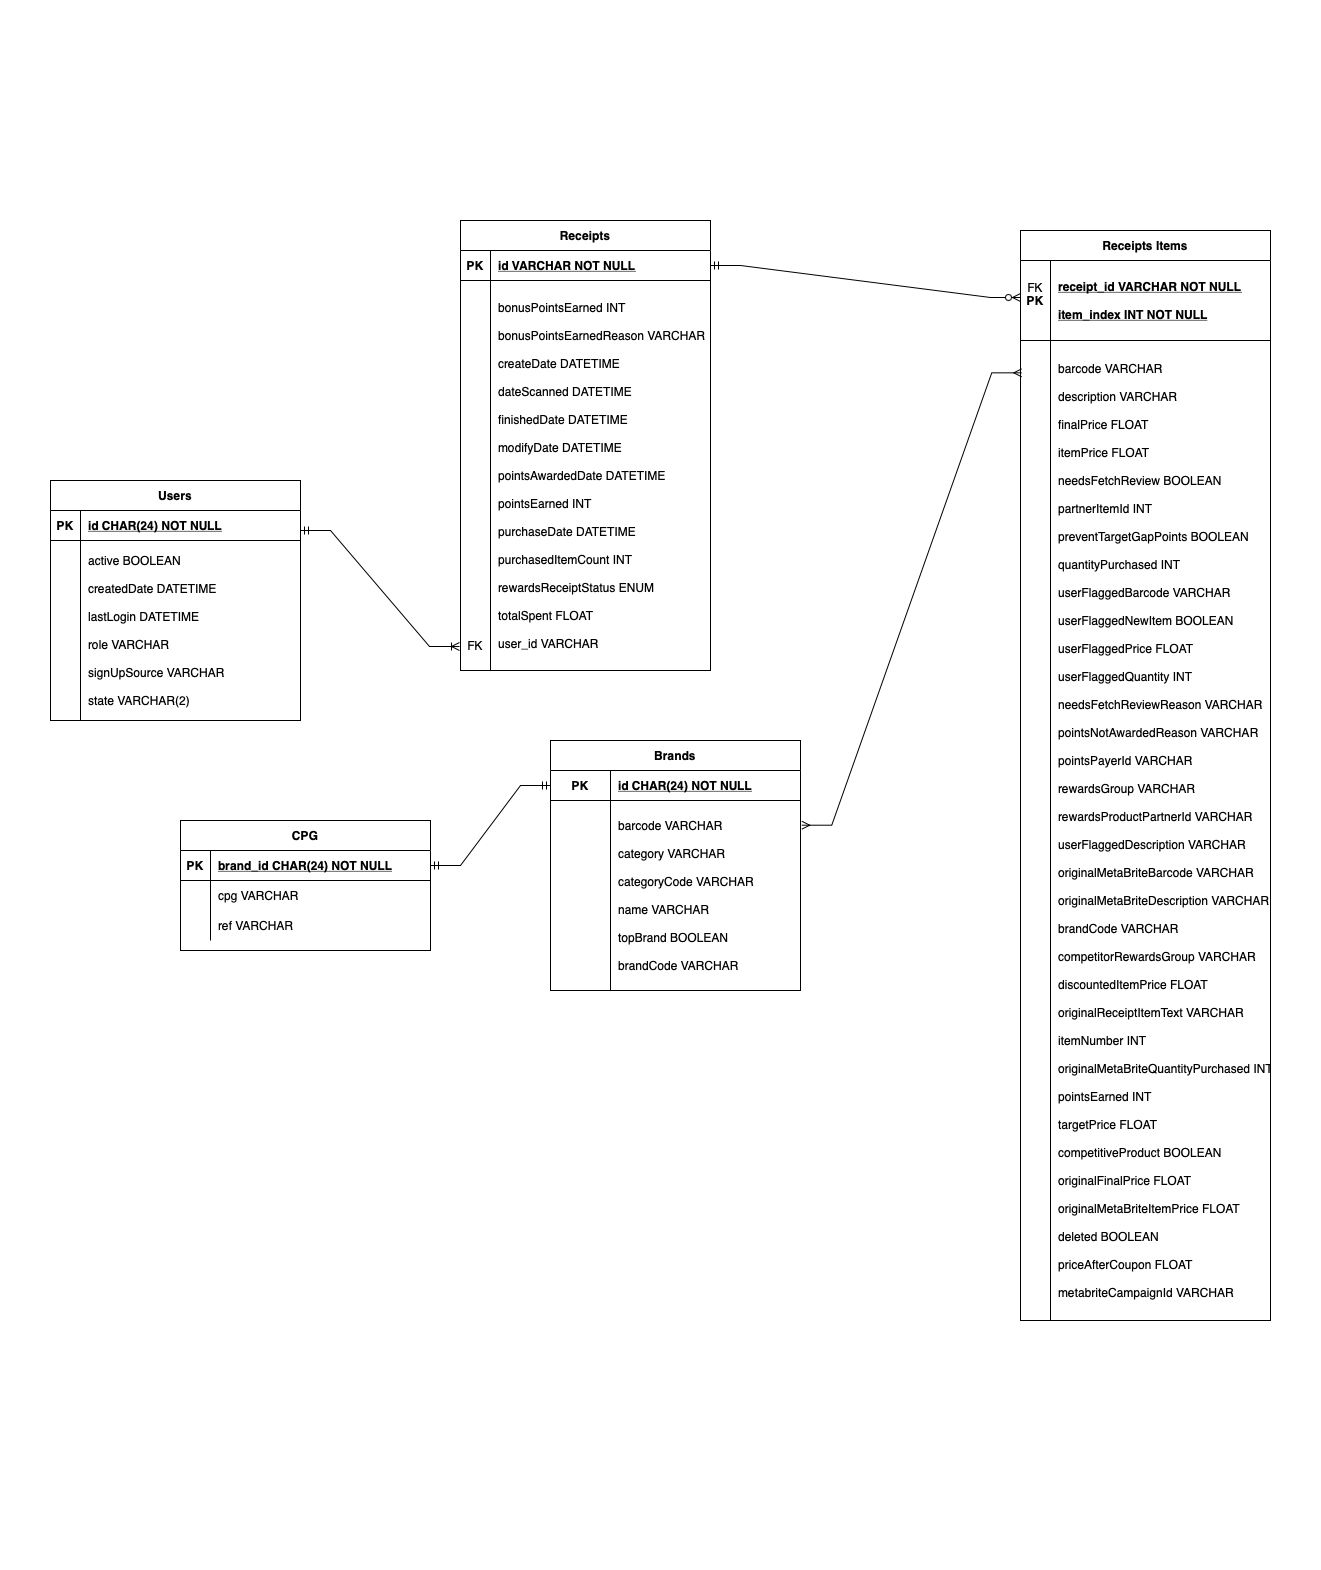

In [26]:
display.Image("Fetch_AE.png")

## __Second: Write queries that directly answer predetermined questions from a business stakeholder__

#### 1. What are the top 5 brands by receipts scanned for most recent month?
#### 2. How does the ranking of the top 5 brands by receipts scanned for the recent month compare to the ranking for the previous month?

Review connections between brands table and receipts table

In [27]:
brands_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167 entries, 0 to 1166
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1167 non-null   object
 1   barcode       1167 non-null   int64 
 2   category      1012 non-null   object
 3   categoryCode  517 non-null    object
 4   name          1167 non-null   object
 5   topBrand      555 non-null    object
 6   brandCode     933 non-null    object
dtypes: int64(1), object(6)
memory usage: 63.9+ KB


In [28]:
print('All id values are unique: ', brands_df['id'].nunique() == len(brands_df))
print('All barcode values are unique: ', brands_df['barcode'].nunique() == len(brands_df))

All id values are unique:  True
All barcode values are unique:  False


In [29]:
bar_code_duplicates = brands_df['barcode'].duplicated().sum()
print('There are', bar_code_duplicates, 'duplicates in barcode column.')

There are 7 duplicates in barcode column.


In [30]:
# the 7 distinct duplicate values detected affected the below 14 records
brands_df[brands_df.duplicated(subset=['barcode'], keep=False)]

,id,barcode,category,categoryCode,name,topBrand,brandCode
9,5c408e8bcd244a1fdb47aee7,511111504788,Baking,NaN,test,<NA>,TEST
20,5c4699f387ff3577e203ea29,511111305125,Baby,NaN,Chris Image Test,<NA>,CHRISIMAGE
129,5a7e0604e4b0aedb3b84afd3,511111504139,Beverages,NaN,Chris Brand XYZ,<NA>,CHRISXYZ
152,5c45f91b87ff3552f950f027,511111204923,Grocery,NaN,Brand1,True,0987654321
194,5d6415d5a3a018514994f429,511111605058,Magazines,NaN,Health Magazine,<NA>,511111605058
299,5a8c33f3e4b07f0a2dac8943,511111504139,Grocery,NaN,Pace,False,PACE
412,5ccb2ece166eb31bbbadccbe,511111504788,Condiments & Sauces,NaN,The Pioneer Woman,<NA>,PIONEER WOMAN
467,5c409ab4cd244a3539b84162,511111004790,Baking,NaN,alexa,True,ALEXA
536,5d6027f46d5f3b23d1bc7906,511111204923,Snacks,NaN,CHESTER'S,<NA>,CHESTERS
651,5d642d65a3a018514994f42d,511111305125,Magazines,NaN,Rachael Ray Everyday,<NA>,511111305125


In [31]:
receipt_items_df['brandCode'].info()
brands_df[brands_df['brandCode'].isnull()].head()

<class 'pandas.core.series.Series'>
RangeIndex: 6941 entries, 0 to 6940
Series name: brandCode
Non-Null Count  Dtype 
--------------  ----- 
2600 non-null   object
dtypes: object(1)
memory usage: 54.4+ KB


,id,barcode,category,categoryCode,name,topBrand,brandCode
0,601ac115be37ce2ead437551,511111019862,Baking,BAKING,test brand @1612366101024,False,NaN
11,57c08106e4b0718ff5fcb02c,511111102540,NaN,NaN,MorningStar,<NA>,NaN
18,5fb28549be37ce522e165cb5,511111317364,Baking,BAKING,test brand @1605535049181,False,NaN
23,5332f5fee4b03c9a25efd0bd,511111303947,NaN,NaN,Bottled Starbucks,<NA>,NaN
24,5332fa7ce4b03c9a25efd22e,511111802914,NaN,NaN,Full Throttle,<NA>,NaN


__Data Quality Issue Observation__:

While exploring the `brands_df` and `receipts_items_df` tables, I found no obvious relationship between them. The `barcode` and `brandCode` fields are the primary fields that overlap. However, `brandCode` is not an appropriate connector due to not every brand nor every receipt item populating that value. `barcode` on the other hand at least had 100% of rows having a non-null value. However, `barcode` does contain 7 duplicate values, but otherwise contains 1160 unique values (1160 unique count/1167 total row count = 99%). Although the `barcode` column does not have a strictly one-to-one relationship with the `id` column, it currently provides the closest analytical linkage. For now, I plan to use the `barcode` field to connect the tables. However, we should consult with stakeholders to determine if an additional column can be used alongside barcode (as a composite key) to uniquely link the `brands_df` and `receipts_items_df` tables for more accurate analysis. For due diligence, I also confirmed that each row in the table at least represents a unique brand with a unique primary key.

__SQL Query (SQLite)__

In [32]:
sqldf('''
    SELECT 
        b.name AS brand_name, 
        COUNT(DISTINCT CASE 
                        WHEN strftime('%Y-%m', r.dateScanned) = strftime('%Y-%m', 'now', '-2 month') 
                        THEN ri.receipt_id
                    END) AS scan_count_last_month,
        COUNT(DISTINCT CASE 
                        WHEN strftime('%Y-%m', r.dateScanned) = strftime('%Y-%m', 'now', '-1 month') 
                        THEN ri.receipt_id
                    END) AS scan_count_current_month
    FROM 
        brands_df b
    INNER JOIN 
        receipt_items_df ri
        ON b.barcode = ri.barcode
    LEFT JOIN 
        receipts_df r
        ON r.id = ri.receipt_id
    WHERE 
        strftime('%Y-%m', r.dateScanned) >= strftime('%Y-%m', 'now', '-2 month')
    GROUP BY 
        b.id
    ORDER BY 
        scan_count_current_month DESC, 
        r.dateScanned DESC
    LIMIT 5
''')

,brand_name,scan_count_last_month,scan_count_current_month


Observation: The query above helps us identify the top 5 brands scanned in the past month and the month prior, based on the number of unique receipts, without counting multiple items of the same brand within a single receipt. Currently, no data is showing since no receipts were scanned in the past two months at the time of this report (2024-11).

Brands consistently appearing at the top of this list could represent high-potential business partners or clients for Fetch Rewards.

#### 3. When considering average spend from receipts with `rewardsReceiptStatus` of `Accepted` or `Rejected`, which is greater?
#### 4. When considering total number of items purchased from receipts with `rewardsReceiptStatus` of `Accepted` or `Rejected`, which is greater?

Review receipts table

In [33]:
receipts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       1119 non-null   object        
 1   bonusPointsEarned        544 non-null    float64       
 2   bonusPointsEarnedReason  544 non-null    object        
 3   createDate               1119 non-null   datetime64[ns]
 4   dateScanned              1119 non-null   datetime64[ns]
 5   finishedDate             568 non-null    datetime64[ns]
 6   modifyDate               1119 non-null   datetime64[ns]
 7   pointsAwardedDate        537 non-null    datetime64[ns]
 8   pointsEarned             609 non-null    float64       
 9   purchaseDate             671 non-null    datetime64[ns]
 10  purchasedItemCount       635 non-null    float64       
 11  rewardsReceiptStatus     1119 non-null   object        
 12  totalSpent               684 non-n

In [34]:
receipts_df['rewardsReceiptStatus'].unique()

array(['FINISHED', 'REJECTED', 'FLAGGED', 'SUBMITTED', 'PENDING'],
      dtype=object)

To analyze questions 3 and 4, we will leverage the `id`, `rewardsReceiptStatus`, and `totalSpend` columns in the `receipts_df` table. The `id` column serves as a unique identifier for different receipts, while the `rewardsReceiptStatus` column contains complete data with predefined options. This allows us to filter for the values `FINISHED` and `REJECTED`, enabling us to clearly segment the data into relevant groups for analysis. One minor point to note is that, in our predefined questions, we're asked to analyze `ACCEPTED` and `REJECTED` instead of `FINISHED` and `REJECTED`. We should clarify with stakeholders if `FINISHED` and `ACCEPTED` are equivalent.

__Data Quality Issue__:
For data completeness issue, only 60% (684/1119) of the `totalSpend` values are non-null in this table. I excluded rows with null totalSpend values for now. However, we should clarify with stakeholders whether we should exclude rows with null values or treat them as 0 to ensure more accurate statistics.

__SQL Query (SQLite)__

In [35]:
sqldf('''
    SELECT 
      rewardsReceiptStatus, 
      COUNT(id) AS countStatus, 
      SUM(purchasedItemCount) AS countItemsPurchased, 
      SUM(purchasedItemCount)/ COUNT(purchasedItemCount) AS averageItemsPurchased, 
      SUM(totalSpent)/COUNT(id) AS averageTotalSpent
    FROM receipts_df r
    WHERE (rewardsReceiptStatus = 'FINISHED' OR rewardsReceiptStatus = 'REJECTED' ) AND totalSpent IS NOT NULL
    GROUP BY rewardsReceiptStatus
''')

,rewardsReceiptStatus,countStatus,countItemsPurchased,averageItemsPurchased,averageTotalSpent
0,FINISHED,518,8184.0,15.799228,80.854305
1,REJECTED,71,173.0,2.436620,23.326056


Observation: The FINISHED receipts have both a higher average total spend and a greater number of items purchased. However, the latter fact could obviously be a contributing factor to the former (more items bought should mean more items spent). To better contextualize this data, I've also included the count of receipts and the average number of items purchased on each receipt. As you can see, the 518 FINISHED receipts have an average count of items purchased of almost 15.7 items while the 71 REJECTED receipts have an average of 2.4. This aligns with the fact that REJECTED receipts are often those that don’t meet the necessary criteria to qualify for rewards, correlating with lower purchase amounts and fewer items.

As a positive, FINISHED receipts represent a substantial number of the receipts we've received. On the other hand, the number of items and average spend for REJECTED receipts suggests that there might be room for improvement in the validation process or customer experience for rejected receipts. If the rejection reasons are better understood and addressed, it could help increase customer satisfaction and spending.

## __Third: Evaluate Data Quality Issues__

__Summary: Identified Data Quality Issues__
1. __Duplicative Entries__: Tables either contain multiple duplicative entries or fields that are expected to be unique are not.
2. __Sparse Data and Null/Empty Values__: Tables contain null or missing values.
3. __Cross-Field Validity__: Some tables have unclear relationships.
4. __Possible Stale Data__: Provided data is over 3 years old.
5. __Test Data__: Possible test data in production data set
6. __.tgz File Possibly Suggests Missing Data__: Having only one file in the .tar archived file could suggest there was supposed to be more data that is missing


### 1. Duplicative Entries

In [36]:
dfs_dict = {
    'Brands': {'df': brands_df, 'primary_key': ['id']},
    'Cpg': {'df': cpg_df, 'primary_key': ['brand_id']},
    'Receipts': {'df': receipts_df},
    'Receipt Items': {'df': receipt_items_df, 'primary_key': ['receipt_id', 'item_index']},
    'Users': {'df': users_df, 'primary_key': ['id']},
}

In [37]:
# check uniqueness and completeness
def check_unique_count_duplicates(table_name, primary_key, df):
    if not primary_key:
        print(f'{table_name}: no primary key')
        return
    elif len(primary_key) == 1:
        pk = primary_key[0]
        print(f'{table_name}: {df[pk].nunique() == len(df)}, Number of duplicates: {df[pk].duplicated().sum()}')
        return
    else:
        pk = primary_key
        print(f'{table_name}: {len(df[pk].drop_duplicates()) == len(df)}, Number of duplicates: {df[pk].duplicated().sum()}')
        return


for table_name, value in dfs_dict.items():
    check_unique_count_duplicates(table_name, value.get('primary_key'), value.get('df'))

Brands: True, Number of duplicates: 0
Cpg: True, Number of duplicates: 0
Receipts: no primary key
Receipt Items: True, Number of duplicates: 0
Users: False, Number of duplicates: 283


In [38]:
users_df.duplicated().sum()

np.int64(283)

In [39]:
brands_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167 entries, 0 to 1166
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1167 non-null   object
 1   barcode       1167 non-null   int64 
 2   category      1012 non-null   object
 3   categoryCode  517 non-null    object
 4   name          1167 non-null   object
 5   topBrand      555 non-null    object
 6   brandCode     933 non-null    object
dtypes: int64(1), object(6)
memory usage: 63.9+ KB


In [40]:
brands_df['barcode'].duplicated().sum()

np.int64(7)

__Data Quality Issue__
* __User Table__: Table contains __283 duplicate records__, including non-unique primary key `id`.
* __Brands Table__: `barcode` field contains __7 duplicate records__ where we would typically expect unique barcodes. If this column should be used as a key for the Receipt Items Table, then this field cannot be unique.

Non-unique primary keys compromise data integrity by making it difficult to reliably distinguish between records, leading to inconsistencies. Queries that rely on the primary key may return or update multiple rows, causing inaccurate or unintended results. Additionally, the lack of uniqueness in the primary key prevents the database from optimizing queries, resulting in reduced performance.

Duplication and redundancy in data can also lead to higher storage costs and slower query performance, making data retrieval less efficient. They also increase the risk of inconsistencies when duplicate records are not updated uniformly, potentially leading to conflicting information. This can skew analyses and insights, resulting in inaccurate conclusions and impacting decision-making.

__Suggestion__

These are only 2 of the fields that were investigated that contained duplicate values in different ways (duplicate entries and duplicate values expecting uniqueness). We should first confirm which fields are intended to be unique. Then we can uniquely solve each duplication probably on a case-by-case basis. For example, for the users database, we could consider using auto-increment, hashing methods to create primary keys, or performing a value check with the database before storing new entries. For the brands database, we could consider creating a composite key for accurate data linking. After removing/handling duplicate values, we should establish validation checks to prevent future dupliation/redundancy issues from happening again.

### 2. Sparse Data and Null/Empty Values

To assess the completeness of the data tables, I aim to evaluate the __null count__ and __percentage of null values__ for each column in every table.  
This approach helps identify columns with substantial missing data. My primary focus is on columns where over __50%__ of the values are null, as these may indicate potential data quality issues or areas requiring further investigation, such as whether the missing data is systematic or random and its impact on downstream analyses.

In [41]:
def check_null_values(table_name, df):
    print(
        table_name, '\n',
        pd.DataFrame({
        'Null Count': df.isnull().sum(),
        'Null Percentage': df.isnull().mean().round(4) * 100
        }),
        '\n\n',
    )

for table_name, value in dfs_dict.items():
    check_null_values(table_name, value.get('df'))

Brands 
               Null Count  Null Percentage
id                     0             0.00
barcode                0             0.00
category             155            13.28
categoryCode         650            55.70
name                   0             0.00
topBrand             612            52.44
brandCode            234            20.05 


Cpg 
           Null Count  Null Percentage
brand_id           0              0.0
cpg                0              0.0
ref                0              0.0 


Receipts 
                          Null Count  Null Percentage
id                                0             0.00
bonusPointsEarned               575            51.39
bonusPointsEarnedReason         575            51.39
createDate                        0             0.00
dateScanned                       0             0.00
finishedDate                    551            49.24
modifyDate                        0             0.00
pointsAwardedDate               582            52.01
poi

__Data Quality Issue__

By examining the completeness of each data table, below are the summary of data columns that exceed 50% of null values in each table:
* __Brands__ (2): categoryCode, topBrand
* __Receipts__ (3): bonusPointsEarned, bonusPointsEarnedReason, pointsAwardedDate (Other fields with about 40% of missing values: finishedDate, pointsEarned, purchaseDate, purchasedItemCount, totalSpent)
* __Receipt Items__ (27): barcode, needsFetchReview, preventTargetGapPoints, userFlaggedBarcode, userFlaggedNewItem, userFlaggedPrice, userFlaggedQuantity, needsFetchReviewReason, pointsNotAwardedReason, pointsPayerId, rewardsGroup, rewardsProductPartnerId, userFlaggedDescription, originalMetaBriteBarcode, originalMetaBriteDescription, brandCode, competitorRewardsGroup, itemNumber, originalMetaBriteQuantityPurchased, pointsEarned, targetPrice, competitiveProduct, originalFinalPrice, originalMetaBriteItemPrice, deleted, priceAfterCoupon, metabriteCampaignId 

Columns with over 50% missing values can significantly impact data quality, leading to biased analyses, unreliable models, and skewed insights. The high proportion of missing data can complicate imputation, decrease statistical power, and increase the risk of overfitting or underfitting in machine learning models. Such columns also add complexity to data cleaning, requiring additional time and resources to either impute or drop them. If left unaddressed, they can affect decision-making and undermine the accuracy of business reports.

__Suggestion__

For tables with a lot of sparse data, options include but not limited to:
1. Store in a separate table to reduce the read/write time for uncommon values.
2. Store the sparse fields into a JSON object that is stored in a single field. While this may complicate queries on this column, it can help save storage costs.

### 3. __Cross-Field Validity__

In [42]:
cpg_inspection_df

,cpg,ref
662,55b62995e4b0d8e685c14213,Cogs
1000,55b62995e4b0d8e685c14213,Cpgs
275,5459429be4b0bfcb1e864082,Cpgs
1074,5459429be4b0bfcb1e864082,Cogs
264,53e10d6368abd3c7065097cc,Cogs
282,53e10d6368abd3c7065097cc,Cpgs
482,5332fa12e4b03c9a25efd1e7,Cogs


__Data Quality Issue__

Brands – CPG Table: 1-to-many relationship in `cpg` column
  
During the data preprocessing phase, I identified that the `cpg` column, which was separated from the `brands_df` table, exhibits a _1-to-many_ relationship between `cpg_id` and `ref` (as detailed in `cpg_inspection_df`). 
* To preserve data integrity and maintain the original `brand_id` as the primary key in the new CPG data table, we had to accommodate potential redundancy in the cpg column. This ensures consistency across tables but introduces duplicate data that requires careful management. 
* Additionally, the exact purpose and definition of the CPG collection need further clarification to ensure accurate interpretation and proper utilization of the data.

* __Receipt – Receipt Item__: As our main business derived from the data collected from customers scanning receipts, this data is crucial for meaningful analysis. I aim to analyze the items scanned in each receipt to derive insights. However, currently, only __60%__ of receipt records include item data, leaving 40% with missing values. This gap could lead to incomplete or biased analysis, as missing item data may skew results, affect accuracy in identifying trends, and hinder the ability to perform comprehensive reporting.

In [43]:
receipt_items_df['receipt_id'].nunique() / receipts_df['id'].nunique() * 100

60.67917783735478

__Data Quality Issue__

__Receipt Item – Brand Table__: No clear relationship between the two tables.
  
  During answering __What are the top 5 brands by receipts scanned for most recent month?__ in Section 2, I found out that there's no clear relationship between `receipt_items_df` and `brands_df`, there was no clear primary key or foreign key relationship between these two tables. 
  
  For analysis purpose, I used `barcode` column as the foreign key (Please refer to Section 2 for the decision process), however, the amount of unmatched data also raised my concern in the process:
  
  Lack of overlap between `brands_df` and `receipt_items_df` `barcode` columns: When attempting to join each brand's `barcode` from `brands_df` with the `barcode` field in `receipt_items_df` (focusing on analyzing the top 5 brands scanned from receipts), the join resulted in a significant number of null values. This indicates a __lack of overlap__ between the two datasets. __Consequently, the top 5 results identified may not represent the actual top 5 scanned brands but rather the top 5 that could be meaningfully matched.__ This discrepancy introduces potential inaccuracies, as the analysis may overlook brands with a significant presence in scanned receipts but missing or unmatched barcode values in the brands table. Addressing this issue requires investigating the source of the mismatch and considering alternative strategies to align the datasets effectively.

  We will need further clarification of the CPG collection's purpose and a deeper investigation into the mismatch between datasets to ensure accurate analysis.

__Suggestion__

To address the issue of unmatched data between brands_df and receipt_items_df on the barcode column, I recommend the following approaches:

1. Investigate Mismatches: Review the mismatched values and determine whether it's a business or engineering issue. If it's a business problem, consult stakeholders to fill in missing values. If it's an engineering problem (e.g., inconsistent barcode numbering), raise it with the engineering team for resolution.
2. Explore Other Matching Methods: Given that duplicates were found in the barcodes, ask stakeholders if there are alternative ways to match barcodes, such as adding a composite key or defining a conversion logic for barcodes across tables.
3. Apply Fuzzy Matching: If the barcode field allows for some flexibility or tolerance in values, consider using fuzzy matching techniques to handle slight discrepancies and improve the match rate.

### 4. __Possible Stale Data__

In [44]:
receipts_df['createDate'].max()

Timestamp('2021-03-01 23:17:34.772000')

__Data Quality Issue__

Receipts Table: Depending on the goal of our analysis, the receipts data can be considered noticeably stale, since the latest record date was on 2021-03-01.

This could pose the following issues:

1. It limits the relevance of the analysis, as the data may no longer reflect current trends, behaviors, or market conditions. This outdated information can lead to flawed strategies or decisions, particularly if recent changes in customer preferences or external factors are not accounted for. 

2. The absence of up-to-date records may hinder the ability to validate or compare findings with more recent data sources, reducing the credibility of insights. For applications like forecasting or trend analysis, relying on stale data could produce inaccurate or misleading predictions, further emphasizing the need to address this issue.

__Suggestion__

To keep our data fresh, we could:
1. Set data expiration policies and perform periodic cleanups: Keep only the most recent data in hot storage, while moving stale data to cold storage.
2. Set up automated jobs (e.g., cron jobs, ETL processes) or real-time data streaming (e.g., Kafka) to pull data from sources periodically.
3. Monitor the last sync timestamp to efficiently track new or updated data, and use it to filter and fetch only the most recent records.

### 5. Test Data

In [45]:
brands_with_test_df = brands_df.map(lambda x: 'test' in str(x).lower())
print(brands_with_test_df.values.sum())
brands_df[brands_with_test_df.any(axis=1)].head()

792


,id,barcode,category,categoryCode,name,topBrand,brandCode
0,601ac115be37ce2ead437551,511111019862,Baking,BAKING,test brand @1612366101024,False,NaN
2,601ac142be37ce2ead43755d,511111819905,Baking,BAKING,test brand @1612366146176,False,TEST BRANDCODE @1612366146176
3,601ac142be37ce2ead43755a,511111519874,Baking,BAKING,test brand @1612366146051,False,TEST BRANDCODE @1612366146051
4,601ac142be37ce2ead43755e,511111319917,Candy & Sweets,CANDY_AND_SWEETS,test brand @1612366146827,False,TEST BRANDCODE @1612366146827
5,601ac142be37ce2ead43755b,511111719885,Baking,BAKING,test brand @1612366146091,False,TEST BRANDCODE @1612366146091


In [46]:
users_with_test_df = users_df.map(lambda x: 'test' in str(x).lower())
print("Users: ", users_with_test_df.values.sum())
receipts_with_test_df = receipts_df.map(lambda x: 'test' in str(x).lower())
print("Receipts: ", receipts_with_test_df.values.sum())

Users:  0
Receipts:  0


__Data Quality Issue__

Brands Table: Certain values in the Brands Table contain the word 'test' in at least the `name` field and the `brandCode` field for 792 values. I would infer these to be fake test entries. Users and Receipts table did not have any fields with values that contained the word 'test'. However, that does not mean that there couldn't be other test entries as well that were represented in a different way.

This poses could pose the following issues:

1. Test data or fake data would skew the data, particularly if not appropriately accounted for in queries. Even if the engineer knew to account for test data, it would add unnecessary complexity ot the query.

2. Test data calls into question the validity of other entries without further validation.

__Suggestion__

To keep our productive data clean and accurate, we should flush all data after verifying with stakeholders that this is acutally test data.

### 6. .tgz File Possibly Suggest Missing Data

__Data Quality Issue__

When I initially loaded the data, the users.json.gz was a .tar archived .gzip file, which was not similar to the brands.json.gz file or the receipts.json.gz file. Typcally, we would expect multiple files to be in the .tar archived file, as its intended purpose is to send along a group of file or a directory. While not strictly an issue, it does warrant further questions as to whether there was supposed to be more data that was supposed to be sent along.

__Suggestion__

Verify with stakeholders that there aren't any additional pieces of information that should be passed along.

## __Fourth: Communicate with Stakeholders__

Below is an email written to a stakeholder John (fun fact: there are 3.2 million people named John in the US - if you are reading this and your name is John, this scenario was intentionally created for you. If not, I hope to meet in person to find out your real name soon.) We will assume for now that John doesn't have as much time to get into the weeds, so I won't explain as much technical information in the email, unless he asks for more information when needed.

### Email to Product Lead

Hi John,

I'm Sammi, the analytics engineer working on analyzing the relationship between brands, users, and receipts data at Fetch Rewards. After reviewing the data, I have a few questions for you and your team that would really help us resolve some issues with the existing data. I know there's a lot of questions here, so I'm also happy to set up a meeting to discuss as well.

__Clarification about the Data__
  
- To make sure we're on the same page, could you clarify what the meaning of "Cogs" and "Cpgs" is in the context of the brands dataset?
- Furthermore, could you clarify what the "cpg" field's id and ref attributes refer to? In other words, from where/how are those fields populated?
- I noticed that the same cpg id can be associated with both "Cogs" and "Cpgs," on different brands. Could you clarify why we would be seeing this?
- I couldn't identify a clear relationship between the brands dataset and the receipts dataset. For now, barcode field appears to be the most complete field that exists in both datasets. However, it appears that multiple brands appear to have the same barcode, which I assumed is not possible, but please correct me if I'm wrong. Could you help point out how to identify the brand of item scanned on each receipt from our dataset?
- In regards to the receipts dataset, I noticed that I'm only seeing data prior to March 1, 2021. Do you know where I would be able to access the latest data? This outdated data may compromise the relevance and accuracy of any analysis based on it, particularly for forecasting or trend analysis.

__Data Quality Concerns__

- Upon reviewing the users data set, I noticed that there are __283 duplicate records__. Would you know where these duplicate values came from? Do you have any concerns with have these duplicate records deleted? If not, I will plan to have these duplicate records deleted.
  
- Several fields across tables have substantial missing data (about 50% null values), which may indicate potential data quality issues:
  - Brands Table: categoryCode, topBrand
  - Receipts Table: bonusPointsEarned, pointsAwardedDate, and other fields with 40%+ missing values. Only 60% of receipts recorded the items scanned.
  - Receipts Items Table: There are 27 fields with a high percentage of missing values, such as barcode, pointsEarned, priceAfterCoupon, and more.

  Some of these columns are essential to our analysis, so leaving these gaps unaddressed could result in biased insights or distorted trends. For example, while analyzing the top 5 brands scanned by users this month, I used barcode as the identifier for the brand of the scanned item. However, due to a significant number of unmatched values when mapping two tables, many records were excluded. As a result, the analysis may not reflect the actual top 5 brands but rather the top 5 brands from the explainable and matched subset of data.

  To address this, I recommend setting up a discussion to explore strategies for improving data completeness and ensuring the accuracy of our analyses moving forward.

- Our dataset currently contains several values that would suggest the entries are test entries. For example, our brands dataset contains 792 field entries that contain the word 'test'. While not all of these may legitimately be test entries, some values such as "test brand @1612366101024" would suggest that at least some are. We should purge the entries from our database as including this data in our research could lead to inaccurate conclusions. Who do you think we could loop into help identify and purge test values from our dataset?

__Performance and Scaling Concerns__

As we increase our user base in production, we will see our receipt items database grow significantly. This database already holds many fields, though much of it is sparse, as I mentioned earlier. Therefore, the access to this database will inevitably grow slower in addition to storage concerns. To get ahead of this, one option would be to prepare to shard our database. We could break our database into smaller pieces using either specific ranges of receipt id or specific time periods. Alternatively, we could consider determining a date to archive/compress/purge certain data from our database. In regards to the sparse fields, since we anticipate the receipt items database to be a high traffic area, schema changes could cause downtime. This is more reason to investigate consolidating the fields into a different table or data object that would be more manageable.

__Next Steps__

After making sure we're on the same page for the clarification questions, I recommend addressing the issues of duplicate keys and missing data first, followed by reviewing the cross-field relationships, stale data concerns, and then finally the long-term performance and scaling concerns.

If you'd like to take a closer look my analysis, I've attached a PDF export of my analysis, and I'm happy to set up a meeting to discuss these findings in more detail together. I'd appreciate if you could respond by the end of the week as we have a meeting with management on Tuesday to discuss the company's key performance indicators.

Best regards,

Sammi